### Fake currency classification using Convolution Neural Network. 

In [1]:
from tensorflow.data import AUTOTUNE
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, RandomZoom, RandomContrast, RandomRotation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from pathlib import Path

DATA_DIR = Path('./dataset').with_suffix('')

##### Preparing model, 80% for training and 20% for testing.

In [2]:
batch_size = 16
img_height = 200
img_width = 400

train_ds = image_dataset_from_directory(
    directory=DATA_DIR,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    seed=123,
    subset='training',
)

val_ds = image_dataset_from_directory(
    directory=DATA_DIR,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    seed=123,
    subset='validation',
)

Found 4328 files belonging to 4 classes.
Using 3463 files for training.
Found 4328 files belonging to 4 classes.
Using 865 files for validation.


In [3]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Cnn model

In [4]:
model = Sequential([
  # preprocessing
  Rescaling(1/255, input_shape=(img_height, img_width, 3)),

  # Convolution layers.
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(16, 2, padding='same', activation='relu'),

  Flatten(),

  # Fully connected layers
  Dense(64, activation='relu'),
  Dense(16, activation="relu"),
  Dense(4, activation='softmax')
])

training_summary = []
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 400, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 200, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 200, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 100, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 100, 32)       9

##### Model training

In [10]:
# total epoch : 10 + 5 + 2 + 2 + 1 

his = model.fit(train_ds, validation_data=val_ds, epochs=1)
training_summary.append(his.history)

217/217 [==============================] - 21s 96ms/step - loss: 0.0825 - accuracy: 0.9711 - val_loss: 0.0347 - val_accuracy: 0.9896


$ Training \; Vs \; Testing \; accuracy \; and \; loss $

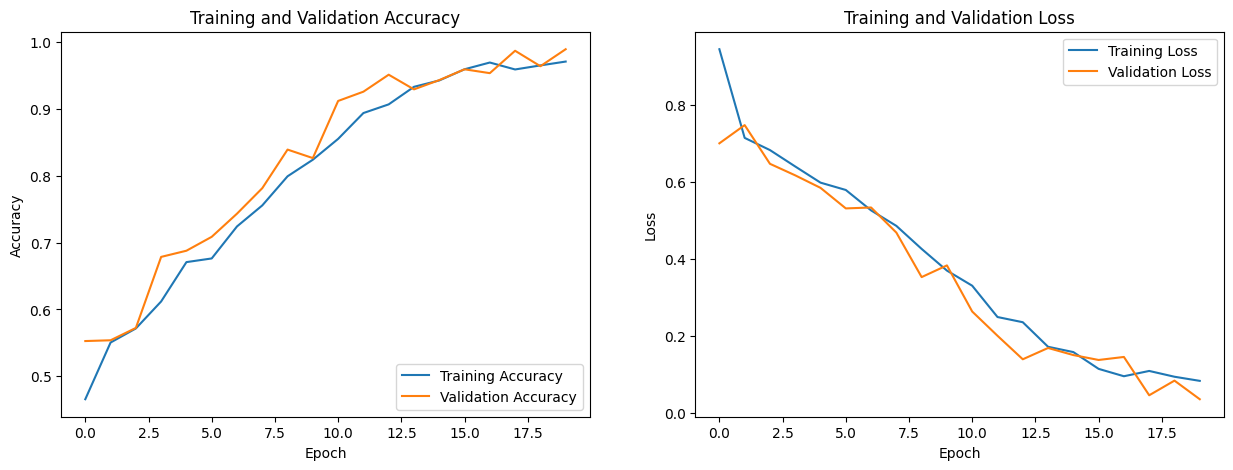

In [11]:
import matplotlib.pyplot as plt
acc, val_acc, loss, val_loss = [],[],[],[]

for i in training_summary :
    acc.extend(i['accuracy'])
    val_acc.extend(i['val_accuracy'])
    loss.extend(i['loss'])
    val_loss.extend(i['val_loss'])

epochs_range = range(len(acc))


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Validating model on testing data.

In [12]:
from numpy import argmax
from tensorflow.math import confusion_matrix
from IPython.display import clear_output

actual, prediction = [], []

for x, y in val_ds:
    actual.extend(y)
    p = model.predict(x)
    prediction.extend([argmax(i) for i in p])

cm = confusion_matrix(labels=actual, predictions=prediction)
clear_output()

$ Measuring \; metrics $

In [13]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

acc = accuracy_score(y_true=actual, y_pred=prediction)
precision = precision_score(actual, prediction, average='weighted')
recall = recall_score(actual, prediction, average='weighted')
f1 = f1_score(actual, prediction, average='weighted')

print('Accuracy : ', "%.2f" % (acc*100))
print('Precision : ', "%.2f" % (precision*100))
print('Recall: ', "%.2f" % (recall*100))
print('F1 Score: ', "%.2f" % (f1*100))

Accuracy :  98.96
Precision :  98.97
Recall:  98.96
F1 Score:  98.96


$ Confusion \; matrix $

<Axes: >

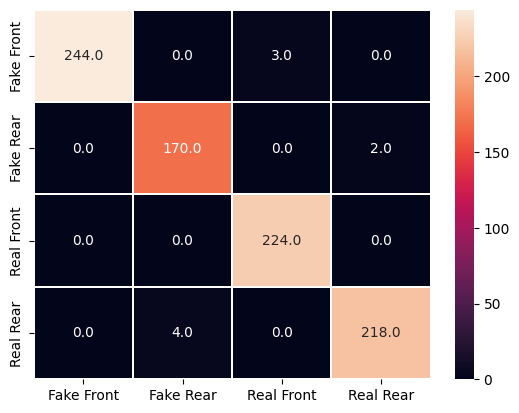

In [14]:
import seaborn as sb

labels = ['Fake Front', 'Fake Rear', 'Real Front', 'Real Rear']

sb.heatmap(cm, annot=True, linewidths=.2, fmt='.1f', xticklabels=labels, yticklabels=labels)

### SAVING MODEL

In [15]:
model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


##### Converting to tf lite model.

In [16]:
from tensorflow import lite

tflite_model = lite.TFLiteConverter.from_saved_model('./cnn_model').convert()

with open('cnn_model.tflite', 'wb') as f:
    f.write(tflite_model)